# Lab 2 - Building and Training a Simple Neural Network (MLP) for MNIST Classification

In this lab, we will build and train a simple neural network (Multi-Layer Perceptron - MLP) to classify handwritten digits from the MNIST dataset using PyTorch. We will also use Weights & Biases (W&B) to track our experiments. 

We start by importing the necessary libraries and setting up the device for computation (CPU or GPU):

In [1]:
# We will use the following libraries in our examples:

import numpy
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn

from torchvision.datasets import MNIST
from torch.utils.data import random_split
from torch.utils.data import DataLoader

import wandb

wandb.login()  # Log in to your W&B account

torch.manual_seed(42)  # For reproducibility

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

wandb: Currently logged in as: kjeziorek (embedded-vision-group) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Using device: cuda


## Dataset Preparation

PyTorch provides a convenient way to download and load a bunch of popular datasets:

https://docs.pytorch.org/vision/main/datasets.html

One of the most popular and simple datasets for image classification is the MNIST dataset, which contains images of handwritten digits (0-9). Each image is 28x28 pixels in size with a single color channel (grayscale) and is labeled with the corresponding digit. Because we are using the labeled version of the dataset, this is a `supervised learning` problem.

To download and load the MNIST dataset, we can use the `torchvision.datasets.MNIST` class:

https://docs.pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST

In [2]:
# We start by downloading the MNIST dataset.
# Select the root directory where the dataset will be stored and set download=True to download the dataset if it's not already present.
dataset = MNIST(root = 'data/', download = True)

# Print the number of samples in the dataset
print(len(dataset))

60000


Once we have the dataset, we can get the some basic information about it, such as the:
- details of the single sample (simple printing the first element of the dataset)
- type of the image (using 'type()' function)
- shape of the image (using '.shape' attribute after converting the image to a numpy array)
- label of the image (using the second element of the dataset tuple)

Also, we can visualize a sample image using matplotlib's `plt.imshow` function (cmap='gray') along with its label using `plt.title` function.
For visualization grid of images, we can use plt.subplots fuction to create a grid of subplots and then iterate through the dataset to display multiple images along with their labels.

https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html

https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html

First sample details: (<PIL.Image.Image image mode=L size=28x28 at 0x7776F8DA0A90>, 5)
Type of the image: <class 'PIL.Image.Image'>
Shape of the image: (28, 28)
Label of the image: 5


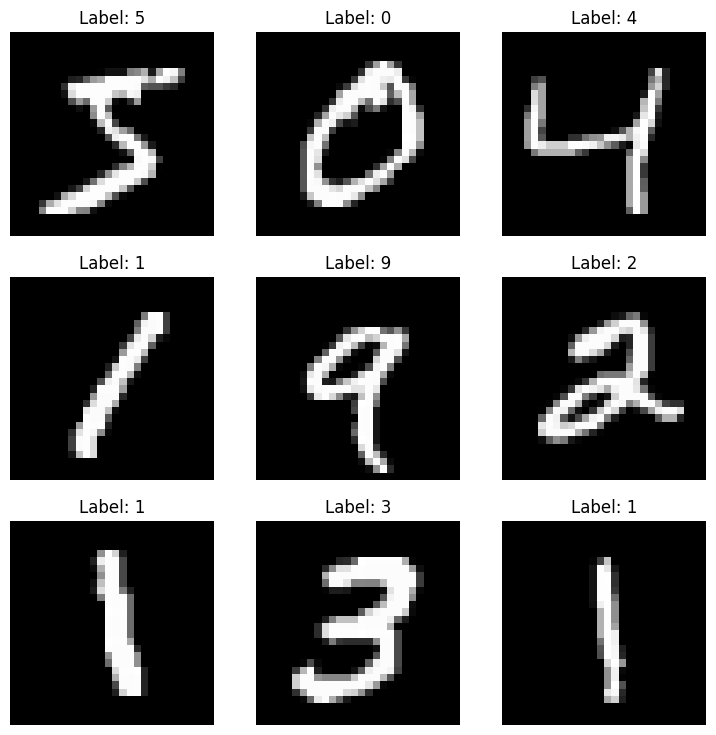

In [3]:
print("First sample details:", dataset[0])
print("Type of the image:", type(dataset[0][0]))
print("Shape of the image:", numpy.array(dataset[0][0]).shape)
print("Label of the image:", dataset[0][1])

fig, ax = plt.subplots(3, 3, figsize = (9, 9))
for i in range(3):
    for j in range(3):
        ax[i, j].imshow(dataset[i * 3 + j][0], cmap = 'gray')
        ax[i, j].set_title(f'Label: {dataset[i * 3 + j][1]}')
        ax[i, j].axis('off')
plt.show()

Now we can see on what type of data we are going to train our model. However, before training the model, we need to preprocess the data. The images in the MNIST dataset are in PIL format, so we need to convert them to PyTorch tensors. We can use the `transforms.ToTensor()` function from the `torchvision.transforms` module to achieve this.

https://docs.pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html

Based on this documentation, we can see that the `ToTensor()` function converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]. So it automatically scales the pixel values to the range [0.0, 1.0] which is a common preprocessing step for image data. It is better to scale the input data to a smaller range as it helps in faster convergence during training.


In [ ]:
dataset = MNIST(root = 'data/', train = True, transform = transforms.ToTensor())

print("First sample details after ToTensor:", type(dataset[0][0]), dataset[0][0].shape, dataset[0][1])

First sample details after ToTensor: <class 'torch.Tensor'> torch.Size([1, 28, 28]) 5


This type of data are ready to be used for training our neural network model. However, we also need a validation/test set. We can generate a validation set by splitting the original training set into two parts: a smaller training set and a validation set. We can use the `random_split` function from the `torch.utils.data` module to achieve this. For testing, we can simply use the test set provided by the MNIST dataset (parameter `train=False`), hovewer for now we will use only train and validation.

> Why we need a validation set? The validation set is used to evaluate the model during training. It helps to monitor the model's performance on unseen data and to prevent overfitting. Overfitting occurs when the model learns the training data too well and performs poorly on unseen data. By using a validation set, we can tune the model's hyperparameters and select the best model based on its performance on the validation set.

Normally, we would also need a test set to evaluate the final model after training. However, for simplicity, we will skip the test set in this lab. 

In [5]:
# We will split the dataset into training and validation sets with 
train_ds, val_ds = random_split(dataset, [48000, 12000])
print(f'Training samples: {len(train_ds)}, Testing samples: {len(val_ds)}')

Training samples: 48000, Testing samples: 12000


Now, the last step in data preparation is to create data loaders for the training and validation sets. Data loaders are used to load the data in batches during training. We can use the `DataLoader` class from the `torch.utils.data` module to achieve this. We will set the batch size to 128 and shuffle only the training data.

Batch size is the number of samples that will be propagated through the network at once. A larger batch size means that the model will be updated more frequently, which can lead to faster convergence. However, a larger batch size also requires more memory and can lead to overfitting. A smaller batch size means that the model will be updated less frequently, which can lead to slower convergence. However, a smaller batch size also requires less memory and can help to prevent overfitting. A common choice for batch size is 16, 32, 64, or 128.

https://medium.com/thedeephub/optimizing-neural-network-training-understanding-batch-size-in-higher-dimensions-7687aa35cb6b

In [6]:
# Create data loaders for the training and validation sets
# We will set the batch size to 128 and shuffle only the training data.

batch_size = 128
train_loader = DataLoader(train_ds, 
                          batch_size, 
                          shuffle = True)

val_loader = DataLoader(val_ds, 
                        batch_size)


# Let's visualize a single batch of training data
for images, labels in train_loader:
    print("Batch image tensor shape:", images.shape)
    print("Batch label tensor shape:", labels.shape)
    break

Batch image tensor shape: torch.Size([128, 1, 28, 28])
Batch label tensor shape: torch.Size([128])


## Model Definition

Now that we have prepared the dataset, we can define our neural network model. We will use a simple Multi-Layer Perceptron (MLP) architecture with two hidden layers. The simple overview of the architecture is shown below (source [link](https://towardsdatascience.com/creating-a-multilayer-perceptron-mlp-classifier-model-to-identify-handwritten-digits-9bac1b16fe10/)):

<img src="https://raw.githubusercontent.com/vision-agh/DNN-Course-media/refs/heads/main/lab2_mlp/figures/overview.png" alt="MLP Architecture for MNIST" width="600"/>


The input layer will have 784 neurons (flatten 28x28 pixels) and the output layer will have 10 neurons (one for each digit class). We will use the ReLU activation function for the hidden layers and output values we will leave as it is. Sometimes, for multi-class classification problems, it is common to use the Softmax activation function in the output layer to convert the raw output scores into probabilities. However, in PyTorch, when using the `CrossEntropyLoss` function, it is not necessary to apply the Softmax activation function in the output layer. This is because `CrossEntropyLoss` combines both the LogSoftmax and Negative Log-Likelihood Loss (NLLLoss) in a single function. Therefore, we can directly use the raw output scores from the model as input to the `CrossEntropyLoss` function without applying Softmax.


> **Why we need activation functions?** Activation functions introduce non-linearity into the model, allowing it to learn complex patterns in the data. Without activation functions, the model would simply be a linear transformation of the input data, which limits its ability to capture intricate relationships.

We will define the model by creating a class that inherits from `nn.Module`. In the `__init__` method, we will define the layers of the model using `nn.Linear` for fully connected layers and `nn.ReLU` for the activation function (we can use torch.nn.functional.relu as well). In the `forward` method, we will define the forward pass of the model by applying the layers and activation functions in sequence. Importantly, we will flatten the input images from 28x28 to 784 using `x.view(-1, 28 * 28)` before passing them through the fully connected layers.

https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html

https://docs.pytorch.org/docs/stable/generated/torch.nn.functional.relu.html


For the number of neurons in the hidden layers, I leave it to you to experiment with different values. Importantly, the number of neurons in the hidden layers should be not to large to avoid overfitting and not too small to avoid underfitting (source: [Link](ttps://medium.com/greyatom/what-is-underfitting-and-overfitting-in-machine-learning-and-how-to-deal-with-it-6803a989c76)).

<img src="https://raw.githubusercontent.com/vision-agh/DNN-Course-media/refs/heads/main/lab2_mlp/figures/overfitting.png" alt="Overfitting vs Underfitting" width="600"/>

To show the results for different architectures, I trained three different models with the following number of neurons in the hidden layers:
- Small: 16 neurons in the first hidden layer and 16 neurons in the second hidden layer
- Medium: 64 neurons in the first hidden layer and 64 neurons in the second hidden layer
- Large: 4096 neurons in the first hidden layer and 4096 neurons in the second

Results are shown in W&B dashboard. https://wandb.ai/deep-neural-network-course/lab2-mlp

In [7]:
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        # Define the layers of the model
        self.fc1 = nn.Linear(28 * 28, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)     # Flatten the image
        x = F.relu(self.fc1(x))     # First hidden layer with ReLU activation
        x = F.relu(self.fc2(x))     # Second hidden layer with ReLU activation
        x = self.fc3(x)             # Output layer
        return x
    

model = MNISTModel().to(device)     # Instantiate the model and move it to the appropriate device (CPU or GPU)
print(model)                        # Print the model architecture

MNISTModel(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


## Learning Algorithm

We already have prepared the dataset and defined the model. For the last step, we need to define the learning algorithm. The learning algorithm consists of three main components:
1. Loss function
2. Optimizer
3. Training loop

We will use the Cross-Entropy Loss function for multi-class classification problems. The Cross-Entropy Loss function measures the difference between the predicted probability distribution and the true probability distribution (one-hot encoded labels). It is commonly used for classification tasks where the output is a probability distribution over multiple classes. In simple terms, it quantifies how well the predicted probabilities match the actual class labels. The goal of training is to minimize this loss function.

https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

We will use the Adam optimizer, which is an adaptive learning rate optimization algorithm that combines the benefits of both the AdaGrad and RMSProp algorithms. It computes individual adaptive learning rates for different parameters from estimates of first and second moments of the gradients. Adam is widely used in deep learning due to its efficiency and effectiveness in training deep neural networks. First important input of the Adam optimizer is the model parameters (model.parameters()) that we want to optimize. The second important input is the learning rate (lr), which controls how much to change the model parameters at each update step. A common choice for the learning rate is 0.01 - 0.001, but it can be adjusted based on the specific problem and dataset.

https://docs.pytorch.org/docs/stable/generated/torch.optim.Adam.html

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), 
                       lr = 0.01)

As for the training loop, we will iterate over the training data for a specified number of epochs. In each epoch, we will perform the following steps:
1. Set the model to training mode using `model.train()`.
2. Iterate over the training data in batches using the training data loader.
3. For each batch, perform the following steps:
   - Zero the gradients of the optimizer using `optimizer.zero_grad()`.
   - Perform the forward pass by passing the input data through the model to get the predictions.
   - Compute the loss by comparing the predictions with the true labels using the loss function.
   - Perform the backward pass by calling `loss.backward()` to compute the gradients of the loss with respect to the model parameters.
   - Update the model parameters using `optimizer.step()` to apply the computed gradients.
4. After each epoch, we will evaluate the model on the validation set to monitor its performance. We will set the model to evaluation mode using `model.eval()` and disable gradient computation using `with torch.no_grad()`.

We will also log the training and validation loss and accuracy to W&B for tracking and visualization. For training loss, we will log the running average of the loss over the 100 batches. For validation loss, we will log the average loss and accuracy over the entire validation set.

In [9]:
num_epochs = 25

# Initialize a new W&B run

wandb.init(
        project="lab2-mlp",                     # do not change this line ! 
        entity="deep-neural-network-course",    # do not change this line ! 
        group="first_training",                       # do not change this line ! 
        name="Kamil Jeziorek medium",                  # change to your name 
        settings=wandb.Settings(save_code=False) # do not change this line ! 
)

# Training loop
for epoch in range(num_epochs):                 # loop over the dataset multiple times

    #  --------- Training phase -------- #
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)   # Move data to the appropriate device

        optimizer.zero_grad()                                   # Zero the parameter gradients      

        outputs = model(inputs)                                 # Forward pass
        loss = criterion(outputs, labels)                       # Compute the loss
        loss.backward()                                         # Backward pass                 
        optimizer.step()                                        # Update the weights

        running_loss += loss.item()                             # Accumulate the loss

        # Print statistics and log to W&B every 100 mini-batches
        if i % 100 == 99:
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 100:.3f}')
            wandb.log({"train/loss": running_loss / 100})
            running_loss = 0.0

    #  --------- Validation phase -------- #
    model.eval()                                    # Set the model to evaluation mode 
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():                           # Disable gradient calculation for validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)   # Move data to the appropriate device
            outputs = model(inputs)                                 # Forward pass
            loss = criterion(outputs, labels)                       # Compute the loss
            val_loss += loss.item()                                 # Accumulate the loss    

            _, predicted = torch.max(outputs.data, 1)               # Get the predicted class (using torch.max())
            total += labels.size(0)                                 # Update the total number of samples
            correct += (predicted == labels).sum().item()           # Update the number of correct predictions

    val_loss /= len(val_loader)
    accuracy = 100 * correct / total
    print(f'Val Loss: {val_loss:.3f}, Accuracy: {accuracy:.2f}%')
    wandb.log({"val/loss": val_loss, "val/accuracy": accuracy})

print('Finished Training')
wandb.finish()

[Epoch 1, Batch 100] loss: 0.507
[Epoch 1, Batch 200] loss: 0.247
[Epoch 1, Batch 300] loss: 0.186
Val Loss: 0.172, Accuracy: 94.95%
[Epoch 2, Batch 100] loss: 0.139
[Epoch 2, Batch 200] loss: 0.143
[Epoch 2, Batch 300] loss: 0.135
Val Loss: 0.166, Accuracy: 95.42%
[Epoch 3, Batch 100] loss: 0.095
[Epoch 3, Batch 200] loss: 0.107
[Epoch 3, Batch 300] loss: 0.133
Val Loss: 0.137, Accuracy: 96.19%
[Epoch 4, Batch 100] loss: 0.078
[Epoch 4, Batch 200] loss: 0.088
[Epoch 4, Batch 300] loss: 0.095
Val Loss: 0.134, Accuracy: 96.22%
[Epoch 5, Batch 100] loss: 0.066
[Epoch 5, Batch 200] loss: 0.084
[Epoch 5, Batch 300] loss: 0.094
Val Loss: 0.144, Accuracy: 96.26%
[Epoch 6, Batch 100] loss: 0.082
[Epoch 6, Batch 200] loss: 0.080
[Epoch 6, Batch 300] loss: 0.080
Val Loss: 0.151, Accuracy: 96.10%
[Epoch 7, Batch 100] loss: 0.058
[Epoch 7, Batch 200] loss: 0.077
[Epoch 7, Batch 300] loss: 0.080
Val Loss: 0.163, Accuracy: 96.10%
[Epoch 8, Batch 100] loss: 0.060
[Epoch 8, Batch 200] loss: 0.063
[Ep

train/loss,█▄▃▃▄▃▃▂▂▂▂▂▂▂▂▁▂▃▂▁▁▂▁▂▂▂▂▁▁▂▁▁▁▁▁▁▁▂▁▂
val/accuracy,▁▃▆▆▆▅▅▄▆▆▇▆▇▇▆▆▇▅▆▆█▆█▆█
val/loss,▃▃▁▁▂▂▃▄▂▃▃▄▃▄▅▅▅▆▅▆▅▆▆██
train/loss,0.05538
val/accuracy,96.75
val/loss,0.24981


After training the model, we can visualize few sample predictions on the validation set. We will display the images along with their predicted labels and true labels using matplotlib.

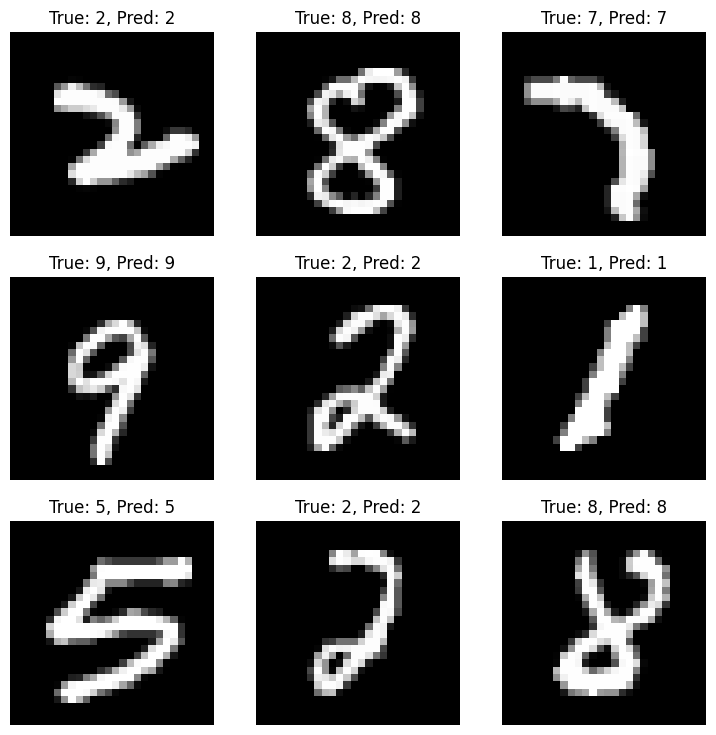

In [10]:
# Lets validate the model on a few samples from the validation set
images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Let's visualize the results
fig, ax = plt.subplots(3, 3, figsize = (9, 9))
for i in range(3):
    for j in range(3):
        ax[i, j].imshow(images[i * 3 + j].cpu().squeeze(), cmap = 'gray')
        ax[i, j].set_title(f'True: {labels[i * 3 + j].item()}, Pred: {predicted[i * 3 + j].item()}')
        ax[i, j].axis('off')
plt.show()

Partially based on: https://medium.com/@waadlingaadil/learn-to-build-a-neural-network-from-scratch-yes-really-cac4ca457efc